## Implementation of a Feed-Forward Neural Network

### Task (a): Constructing a Custom Feed-Forward Neural Network

In this section, we develop a feed-forward neural network (FNN) with three hidden layers using PyTorch. The network follows the given specifications:

- **Input Layer**: Accepts a flattened 28×28 FashionMNIST image (784 input features).
- **Hidden Layers**:
  - **Layer 1**: 512 neurons
  - **Layer 2**: 256 neurons
  - **Layer 3**: 128 neurons
- **Output Layer**: 10 neurons (corresponding to 10 FashionMNIST classes).
- **Activation Function**: Applied after each hidden layer.
- **Dropout**: Used to improve generalization and prevent overfitting.

### Implementation Steps:
1. **Define the `CustomFeedForwardNN` class**:
   - Uses `nn.ModuleList` to handle multiple hidden layers dynamically.
   - Applies the activation function and dropout after each hidden layer.
   - Uses a final linear layer to produce class logits.

2. **Instantiate the Model**:
   - Input size is 784 (28×28).
   - Uses ReLU as the activation function (which can be varied later).
   - Applies a dropout rate of 0.2.

3. **Verify Model Summary**:
   - Uses `torchinfo.summary` to inspect the architecture and parameter count.


In [1]:
import torch.nn as nn
import torch.nn.functional as F

class CustomFeedForwardNN(nn.Module):

  def __init__(self, input_size, num_classes, hidden_dims, dropout, activation_fn):
    super().__init__()

    # Ensure that hidden_dims is a non-empty list
    assert isinstance(hidden_dims, list) and len(hidden_dims) > 0

    # Initialize a ModuleList to store the hidden layers
    self.hidden_layers = nn.ModuleList()

    # Input layer to first hidden layer
    self.hidden_layers.append(nn.Linear(input_size, hidden_dims[0]))

    # Subsequent hidden layers
    for i in range(1, len(hidden_dims)):
      self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

    # Set up the nonlinearity to use between layers.
    self.nonlinearity = activation_fn

    # Set up the dropout layer.
    self.dropout = nn.Dropout(dropout)

    # Set up the final transform to a distribution over classes.
    self.output_projection = nn.Linear(hidden_dims[-1], num_classes)



  def forward(self, x):
    
    # Apply the hidden layers, nonlinearity, and dropout.
    for hidden_layer in self.hidden_layers:
      x = hidden_layer(x)
      x = self.nonlinearity(x)
      x = self.dropout(x)
      
    # Output logits
    out = self.output_projection(x)

    return out

In [2]:
import torch.nn as nn

# Define the model parameters
input_size = 28 * 28  # For 28x28 pixel images
hidden_dims = [512, 256, 128]
num_classes = 10  # Number of output classes in FashionMNIST
dropout_rate = 0.2
activation_fn = nn.ReLU()  # Example activation function

# Instantiate the model
model = CustomFeedForwardNN(input_size, num_classes, hidden_dims, dropout_rate, activation_fn)


In [3]:
# Verification of model information

from torchinfo import summary
summary(model, input_size=(1,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
CustomFeedForwardNN                      [1, 10]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-1                       [1, 512]                  401,920
├─ReLU: 1-2                              [1, 512]                  --
├─Dropout: 1-3                           [1, 512]                  --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-2                       [1, 256]                  131,328
├─ReLU: 1-5                              [1, 256]                  --
├─Dropout: 1-6                           [1, 256]                  --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-3                       [1, 128]                  32,896
├─ReLU: 1-8                              [1, 128]                  --
├─Dropout: 1-9                           [1,

## Experimenting with Activation Functions and Optimizers

### Task (b): Evaluating Model Performance with Different Configurations

In this section, we experiment with various activation functions and optimizers to evaluate their impact on model performance. The goal is to determine which combination yields the best test accuracy on the FashionMNIST dataset.

### Experimental Setup:
1. **Dataset Loading**:
   - The **FashionMNIST** dataset is loaded and transformed into tensors.
   - Training and testing data are handled using PyTorch `DataLoader` with a batch size of **64**.

2. **Activation Functions Tested**:
   - **ReLU** (Rectified Linear Unit)
   - **Sigmoid**
   - **Tanh**

3. **Optimizers Tested**:
   - **SGD (Stochastic Gradient Descent)** with momentum
   - **Adam (Adaptive Moment Estimation)**

4. **Training and Evaluation**:
   - The model is trained for **5 epochs** using a **cross-entropy loss function**.
   - Training accuracy and loss are monitored per epoch.
   - After training, the model is evaluated on the test set, and the test accuracy is recorded.

5. **Result Storage**:
   - The results (activation function, optimizer type, and test accuracy) are stored in a Pandas DataFrame for comparison.


In [4]:
import torch
from torchvision.transforms import transforms 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

### Loading MINST data

# Define Transformation
transform = transforms.ToTensor()

train_dataset = FashionMNIST(root='./torchvision-data',
                             train=True,
                             transform=transform,
                             download=True)

test_dataset = FashionMNIST(root='./torchvision-data', 
                            train=False,
                            transform=transform,
                            download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Simple GPU check
using_GPU = torch.cuda.is_available()
print("Using GPU?", using_GPU)

Using GPU? False


In [5]:
import torch
import torch.optim as optim

def train_and_evaluate_model(activation_fn, optimizer_type, learning_rate=0.001, num_epochs=5):
    """
    Trains and evaluates the model using the given activation function and optimizer.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Instantiate the model
    model = CustomFeedForwardNN(input_size=784, num_classes=10, hidden_dims=[512, 256, 128], dropout=0.2, activation_fn=activation_fn)
    model.to(device)

    # Loss Function
    criterion = nn.CrossEntropyLoss()

    # Optimizer Selection
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.view(images.shape[0], -1).to(device)  # Flatten images
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Evaluate Model
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy

In [6]:
activations = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh()
}

optimizers = ["SGD", "Adam"]

# This line is to test on a single configuration. Before running on all combinations
# train_and_evaluate_model(activation_fn=nn.ReLU(), optimizer_type="SGD")

In [7]:
import pandas as pd

results_df = pd.DataFrame(columns=["Activation", "Optimizer", "Test Accuracy (%)"])

for act_name, act_fn in activations.items():
    for opt in optimizers:
        print(f"\n===== Running: Activation={act_name}, Optimizer={opt} =====")
        acc = train_and_evaluate_model(activation_fn=act_fn, optimizer_type=opt)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            "Activation": [act_name],
            "Optimizer": [opt],
            "Test Accuracy (%)": [acc]
        })], ignore_index=True)


===== Running: Activation=ReLU, Optimizer=SGD =====
Epoch [1/5], Loss: 1.8810, Accuracy: 35.22%
Epoch [2/5], Loss: 0.9625, Accuracy: 62.82%
Epoch [3/5], Loss: 0.7646, Accuracy: 71.50%
Epoch [4/5], Loss: 0.6682, Accuracy: 75.75%
Epoch [5/5], Loss: 0.6078, Accuracy: 78.20%
Test Accuracy: 79.26%

===== Running: Activation=ReLU, Optimizer=Adam =====


C:\Users\ongjy\AppData\Local\Temp\ipykernel_28216\3391244907.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Epoch [1/5], Loss: 0.5651, Accuracy: 79.37%
Epoch [2/5], Loss: 0.4032, Accuracy: 85.28%
Epoch [3/5], Loss: 0.3678, Accuracy: 86.66%
Epoch [4/5], Loss: 0.3426, Accuracy: 87.46%
Epoch [5/5], Loss: 0.3282, Accuracy: 88.03%
Test Accuracy: 87.08%

===== Running: Activation=Sigmoid, Optimizer=SGD =====
Epoch [1/5], Loss: 2.3126, Accuracy: 9.99%
Epoch [2/5], Loss: 2.3102, Accuracy: 10.03%
Epoch [3/5], Loss: 2.3097, Accuracy: 9.94%
Epoch [4/5], Loss: 2.3081, Accuracy: 10.23%
Epoch [5/5], Loss: 2.3077, Accuracy: 10.18%
Test Accuracy: 10.00%

===== Running: Activation=Sigmoid, Optimizer=Adam =====
Epoch [1/5], Loss: 0.8280, Accuracy: 68.75%
Epoch [2/5], Loss: 0.4691, Accuracy: 83.29%
Epoch [3/5], Loss: 0.4092, Accuracy: 85.35%
Epoch [4/5], Loss: 0.3764, Accuracy: 86.53%
Epoch [5/5], Loss: 0.3514, Accuracy: 87.29%
Test Accuracy: 86.27%

===== Running: Activation=Tanh, Optimizer=SGD =====
Epoch [1/5], Loss: 1.3798, Accuracy: 55.54%
Epoch [2/5], Loss: 0.7387, Accuracy: 72.77%
Epoch [3/5], Loss: 0.6

In [8]:
print(results_df)

  Activation Optimizer  Test Accuracy (%)
0       ReLU       SGD              79.26
1       ReLU      Adam              87.08
2    Sigmoid       SGD              10.00
3    Sigmoid      Adam              86.27
4       Tanh       SGD              81.83
5       Tanh      Adam              86.75


## Improving Model Performance

### Task (c): Enhancing the Best Model Configuration

Building upon the insights gained from the experiments in **Task (b)**, we explore two strategies to further improve model performance:

1. **Increasing the Number of Epochs**:
   - The model is trained for **15 epochs** instead of 5, allowing it more time to learn meaningful patterns.

2. **Implementing a Learning Rate Scheduler**:
   - We employ a **StepLR scheduler** that reduces the learning rate by a factor of **0.5 every 5 epochs**.
   - This helps the model converge more efficiently and prevents it from getting stuck in local minima.

### Implementation:
- The training process remains similar to **Task (b)** but with extended training time.
- The **learning rate scheduler** is introduced to gradually adjust the learning rate.
- The **Adam optimizer with ReLU activation** is chosen based on previous experiments.

### Expected Impact:
- **More epochs** should allow the model to improve accuracy by refining its understanding of the data.
- **Learning rate scheduling** ensures smoother convergence, preventing overshooting and stagnation.
- The best-performing configuration from **Task (b)** is used as a baseline for further enhancements.


In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_with_scheduler(activation_fn, optimizer_type, learning_rate=0.001, num_epochs=15):
    """
    Train and evaluate the improved model with learning rate scheduling.
    Plots training loss and accuracy over epochs.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CustomFeedForwardNN(input_size=784, num_classes=10, hidden_dims=[512, 256, 128], dropout=0.2, activation_fn=activation_fn)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    
    # Optimizer Selection
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    # Lists to store loss and accuracy
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        scheduler.step()  # Adjust learning rate

        # Store values for plotting
        epoch_losses.append(running_loss / len(train_loader))
        epoch_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses[-1]:.4f}, Accuracy: {train_accuracy:.2f}%")

    # **Plot Training Loss and Accuracy**
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')

    plt.show()

    # **Test Evaluation**
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy


Training Improved Model (LR Scheduler, 15 Epochs)
Epoch [1/15], Loss: 0.5637, Accuracy: 79.36%
Epoch [2/15], Loss: 0.4039, Accuracy: 85.39%
Epoch [3/15], Loss: 0.3665, Accuracy: 86.71%
Epoch [4/15], Loss: 0.3418, Accuracy: 87.50%
Epoch [5/15], Loss: 0.3290, Accuracy: 87.86%
Epoch [6/15], Loss: 0.2879, Accuracy: 89.25%
Epoch [7/15], Loss: 0.2777, Accuracy: 89.71%
Epoch [8/15], Loss: 0.2690, Accuracy: 89.93%
Epoch [9/15], Loss: 0.2595, Accuracy: 90.27%
Epoch [10/15], Loss: 0.2535, Accuracy: 90.42%
Epoch [11/15], Loss: 0.2317, Accuracy: 91.28%
Epoch [12/15], Loss: 0.2239, Accuracy: 91.57%
Epoch [13/15], Loss: 0.2186, Accuracy: 91.67%
Epoch [14/15], Loss: 0.2156, Accuracy: 91.82%
Epoch [15/15], Loss: 0.2083, Accuracy: 92.06%


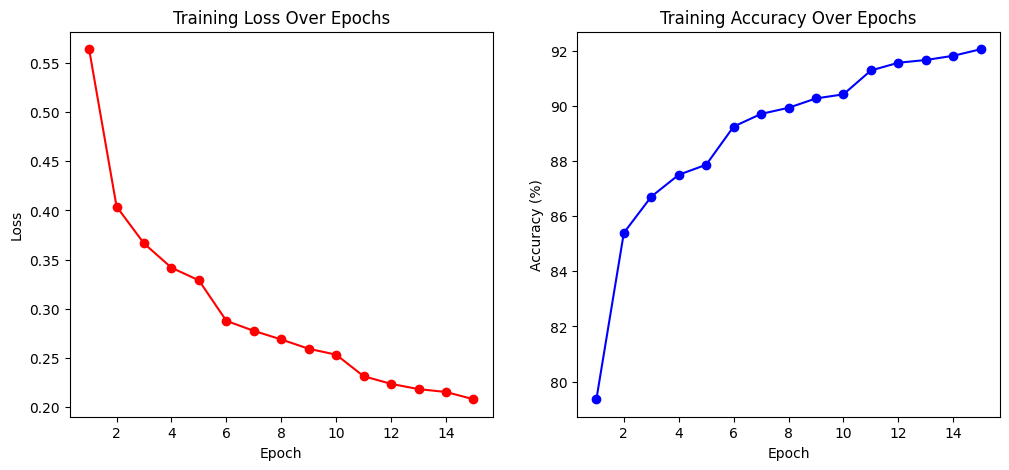

Final Test Accuracy: 89.35%


In [10]:
# Train the improved model
print("Training Improved Model (LR Scheduler, 15 Epochs)")
activation_fn = nn.ReLU()
optimizer = "Adam"

improved_model = train_with_scheduler(activation_fn, optimizer, num_epochs=15)
